In [1]:
import os
import numpy as np
from matplotlib.colorbar import ColorbarBase
import matplotlib.pyplot as plt
import struct
from random import shuffle
import math
from scipy.special import factorial
from scipy.stats import pearsonr

In [2]:
class emc(object):
    def __init__(self, contrast_filename="contrast.dat", data_filename="data.dat"):
        #If contrast.dat is present, use it to initialize reconstruction parameters.
        self.contrast_filename = contrast_filename
        self.data_filename = data_filename
        
        if os.path.isfile(self.contrast_filename):
            tmp = np.fromfile(self.contrast_filename, sep=" ")
            self.l = int(tmp[0])
            self.numConf = int(tmp[1])
            self.contrast = (tmp[2:]).reshape(self.l, self.l)
        else:
            print("Warning: contrast.dat is missing. You'll have to make one.")
            self.l = 50
            self.contrast = None
            self.numConf = 1
        #Default signal parameters
        self.numPatterns = 10000
        self.sigLvl = 10.
        #Default has no blanks
        self.hasBackground = False
        self.hitRate = 1.
        self.bgLvl = 0.
        self.sparseData = {}
        #Default number of iterations
        self.numIter = 100

    def sampleData(self, readFrac=1., verbose=True):
        #Check if data.dat is present
        #Read and store the sparse data format as a dictionary
        if not os.path.isfile(self.data_filename):
            print(f"{self.data_filename} is not present. Skipping file read.")
            return 1
        #Start to parse file
        f = open(self.data_filename, "rb")
        inD = f.read(32)
        (self.num_data,) = struct.unpack('i', inD[:4])
        
        (self.present_conf,) = struct.unpack('i', inD[4:8])
        
        (self.mean_total_photons,) = struct.unpack('d', inD[8:16])
        (self.len_,) = struct.unpack('i', inD[16:20])
        (self.tomo_len,) = struct.unpack('i', inD[20:24])
        (self.m_info_given_choice,) = struct.unpack('d', inD[24:32])
        #Print header for sanity check
        if verbose:
            # print("num_data: %d"%self.num_data)
            # print("present_conf: %d"%self.present_conf)
            print("mean_total_photons: %lf"%self.mean_total_photons)
            # print("len: %d"%self.len_)
            # print("tomo_len: %d"%self.tomo_len)
            ##print("m_info_given_choice: %lf"%self.m_info_given_choice)
        #Flush out existing sparseData dictionary.
        self.sparseData = {}
        #Read only a fraction of images. 
        for dNum in range(int(readFrac*self.num_data)):
            self.sparseData[dNum] = {}
            #Read the one photons
            bNumOnes = f.read(2)
            (numOnes,) = struct.unpack("H", bNumOnes)
            bOnes = f.read(2*numOnes)
            self.sparseData[dNum]['o'] = []
            for o in range(numOnes):
                (oLoc,) = struct.unpack("H", bOnes[2*o:2*(o+1)]) 
                (self.sparseData[dNum]['o']).append(oLoc)
            #Read the multiple photons
            bNumMultis = f.read(2)
            (numMultis,) = struct.unpack("H", bNumMultis)
            bMultis = f.read(2*numMultis)
            self.sparseData[dNum]['m'] = []
            for m in range(numMultis//2):
                (mLoc,) = struct.unpack("H", bMultis[4*m:4*m+2])
                (mPh,) = struct.unpack("H", bMultis[4*m+2:4*m+4])
                (self.sparseData[dNum]['m']).append([mLoc, mPh])
        f.close()


    def sparseToDense(self, imgSlice):
        #Convert a slice of the sparse data for the format into a dense array
        #This function should return an array
        if len(self.sparseData) == 0:
            res = self.sampleData()
            if res == 1:
                return 
        arr = np.zeros(self.len_*self.len_)
        cD = self.sparseData[imgSlice]
        for o in cD['o']:
            arr[o] = 1.
        for m in cD['m']:
            arr[m[0]] = arr[m[1]]
        return arr.reshape(self.len_,-1)

    def showNineRandomData(self):
        if len(self.sparseData) == 0:
            res = self.sampleData()
            if res == 1:
                return 
        keys = list(self.sparseData.keys())
        shuffle(keys)
        fig,axes = plt.subplots(3,3, figsize=(9,10))
        ccmap = plt.cm.get_cmap('bone', 3)
        for kk,ax in zip(keys[:9], axes.ravel()):
            arr = self.sparseToDense(kk)
            im = ax.imshow(arr, cmap=ccmap, vmax=2)
            ax.set_title("Img %d"%kk)
        cbar_axes = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        cb = ColorbarBase(cbar_axes, cmap=ccmap, ticks=range(3), format='%1i')
        
    def showAverageData(self):
        if len(self.sparseData) == 0:
            res = self.sampleData()
            if res == 1:
                return 
        keys = self.sparseData.keys()
        hostArr = np.zeros((self.len_,self.len_))
        for nn,kk in enumerate(keys):
            arr = self.sparseToDense(kk)
            hostArr += arr
        hostArr /= 1.*len(keys)
        # fig = plt.figure(figsize=(6,5))
        # plt.imshow(hostArr, cmap='bone')
        # plt.title("%d-image average data"%len(keys))
        # ax2 = fig.add_axes([0.90, 0.1, 0.03, 0.8])
        # plt.title("photons")
        # cb = ColorbarBase(ax2, cmap='bone', ticks=np.arange(0,1,0.1))
        return hostArr

# Task 1
### Discussion
$$\begin{align}
\mathcal{L}(K|W_j) &\equiv \prod_i P(K_i|W_{ji}) = \prod_i \frac{\text{e}^{-W_{ji}} W_{ji}^{K_i}}{K_i!}\;.
\end{align}$$ 
When we are given a particular model $W$, we can make our model oritate to get four orientated models $W_{j}, j={0,1,2,3}$, then we can compute $\mathcal{L}(K|W_j)$ to choose the optimal $j$ to maximize the likelihood. Finally, we can say which orientation $j$ is the most likely orientation.
***Taking the ground truth as our $W$ to calculate the average data likelihood, here we choose data_030.dat as our example***
$$\begin{align}
\mathcal{L}(\{K\}|W_j) &\equiv \langle \prod_i P(K_i|W_{ji}) \rangle_K\;.
\end{align}$$ 


In [3]:
def readGroudTruth(class_emc):
    '''
    Read groud truth in 50,50 matrix and also rotate it to get 4 orientation's matrix.
    ----------------------------------------------------------------
    input: class_emc which is emc class
    output:
    groundTruth (50, 50)
    groundTruthMat (4, 2500)
    groundTruthMatNewaxis (4, 1, 2500)
    '''
    groundTruth = class_emc.contrast
    groundTruthMat =np.array([groundTruth.flatten(), (np.rot90(groundTruth, k=1)).flatten(), (np.rot90(groundTruth, k=2)).flatten(),(np.rot90(groundTruth, k=3)).flatten()])
    # Dim [4, 2500] former is rotation latter is pixel
    groundTruthMatNewaxis = groundTruthMat[:, np.newaxis,:]
    return groundTruth, groundTruthMat, groundTruthMatNewaxis

In [4]:
def readMeasurement(class_emc):
    '''
    Read measurement data in all patterns and get (10000, 2500) matrix for it.
    ----------------------------------------------------------------
    input: class_emc which is emc class
    output:
    measureMat (10000, 2500)
    measureMatNewaxis (1, 10000, 2500)
    '''
    measureMat = []
    for i in range(10000):
        sample = (class_emc.sparseToDense(i)).flatten()
        measureMat.append(sample)
    measureMat = np.array(measureMat)
    # Dim (10000,2500) former is 10000 patterns, every pattern has 2500 pixers' occupation
    measureMatNewaxis = measureMat[np.newaxis, :, :]
    return measureMat, measureMatNewaxis

In [5]:
emc30 = emc(data_filename="data_030.dat")
# emc0.sampleData(readFrac=1.0)
averData = emc30.showAverageData()
## Ground truth matrix
groundTruth, groundTruthMat, groundTruthMatNewaxis = readGroudTruth(emc30)
# Dim (4, 1, 2500)
## Measurement matrix
measureMat, measureMatNewaxis = readMeasurement(emc30)
# Likelihood Matrix which take the ground truth for known condition 
likelihoodGTMat = (np.exp(-groundTruthMatNewaxis) * (groundTruthMatNewaxis** measureMatNewaxis))/ factorial(measureMatNewaxis)
# Dim (4, 10000, 2500) ~j rotation,k pattern, i pixels
loglikelihoodGTprod = np.sum(np.log(likelihoodGTMat), axis = -1) - np.max(np.sum(np.log(likelihoodGTMat), axis = -1))
# prevent from numerical underflow
averDataLikelihood = np.mean(np.exp(loglikelihoodGTprod), axis=1)
averDataLikelihoodNormal = averDataLikelihood /np.sum(averDataLikelihood)
# Dim (4) different rotations, Normalized version
print("The average data likelihood (normalized) for data_030.dat with different orientations are" +str(averDataLikelihoodNormal))

mean_total_photons: 30.000000


The average data likelihood (normalized) for data_030.dat with different orientations are[0.13411573 0.09571899 0.01891681 0.75124847]


# Task 2
**Your task is to compute the mutual information between each pattern $K$ and its orientation $\Omega_K$ given the ground truth model $W^*$.**
 
$$\begin{align}
\mathbb{I}(\Omega_K, K|W^*) = \sum_{\Omega_K, K} P(\Omega_K, K|W^*) \log{\left( \frac{P(\Omega_K, K|W^*)}{P(\Omega)P(K|W^*)} \right)}\;.
\end{align}$$ 
Assume that the orientations are independent of the pattern and uniformly distributed: $P(\Omega_K|W^*) = P(\Omega)=\frac{1}{4}$. 

**Discuss how this mutual information tells us how well we can infer the orientations of each pattern.**
### Discussion
Mutual information tell us the information gain if we update from a model that
treats the two variables as independent $p(x)p(y)$ to one that models their true joint density $p(x,y)$. The higher MI information between the datasets and the ground truth, the better we can infer the orientations of each pattern correctly. If we check the $ \log{\left( \frac{P(\Omega_K, K|W^*)}{P(\Omega)P(K|W^*)} \right)}$, we will find that $\log{4}$ is the highest value it can reach. We can see that after 100, MI reaches the best. 

In [6]:
def mutualInfor(filename):
    emcFile = emc(data_filename=filename)
    # emc100 = emc(data_filename="data_050.dat")
    ## Ground truth matrix
    groundTruth, groundTruthMat, groundTruthMatNewaxis = readGroudTruth(emcFile)

    ## Measurement matrix
    measureMat, measureMatNewaxis = readMeasurement(emcFile)

    # Likelihood Matrix which take the ground truth for known condition 
    likelihoodGTMat = (np.exp(-groundTruthMatNewaxis) * (groundTruthMatNewaxis** measureMatNewaxis))/ factorial(measureMatNewaxis)
    # Dim (4, 10000, 2500) ~j rotation,k pattern, i pixels

    loglikelihoodGTprod = np.sum(np.log(likelihoodGTMat+np.finfo(float).eps), axis = -1) 
    
    likelihoodGTprod = np.exp(loglikelihoodGTprod-np.max(loglikelihoodGTprod))
    # (4, 10000)
    likelihoodGTprodNormal = likelihoodGTprod/ np.sum(likelihoodGTprod, axis =0)[np.newaxis,:]
    likelihoodGTprodNormal = likelihoodGTprodNormal/ np.sum(likelihoodGTprodNormal, axis=-1)[:,np.newaxis]
    logLatterPart = np.log(4.0*likelihoodGTprodNormal/(np.sum(likelihoodGTprodNormal, axis = 0)))
    return np.exp(np.sum((1.0/4*likelihoodGTprodNormal*logLatterPart)))

mean_total_photons: 10.000000
mean_total_photons: 20.000000
mean_total_photons: 30.000000
mean_total_photons: 40.000000
mean_total_photons: 50.000000
mean_total_photons: 60.000000
mean_total_photons: 70.000000
mean_total_photons: 80.000000
mean_total_photons: 90.000000
mean_total_photons: 100.000000
mean_total_photons: 110.000000
mean_total_photons: 120.000000
mean_total_photons: 130.000000
mean_total_photons: 140.000000
mean_total_photons: 150.000000
mean_total_photons: 160.000000
mean_total_photons: 170.000000
mean_total_photons: 180.000000
mean_total_photons: 190.000000
mean_total_photons: 200.000000


Text(0, 0.5, 'exponential(mutual information)')

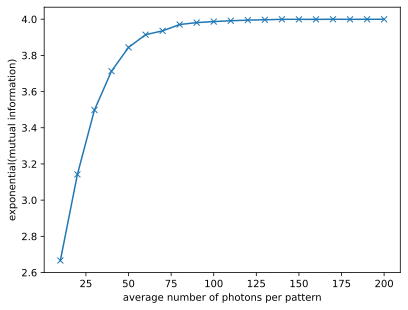

In [7]:
nameList = ["010", "020", "030", "040", "050", "060", "070", "080", "090", "100", "110", "120", "130", "140", "150","160", "170", "180", "190", "200"]
mutualInforList =[]
for i in nameList:
    fileName = "data_" + i +".dat"
    mutualInforList.append(mutualInfor(fileName))

plt.plot(np.arange(10, 210,10), np.array(mutualInforList), 'x-')
plt.xlabel("average number of photons per pattern")
plt.ylabel("exponential(mutual information)")


# Task 3
**Your task is to reconstruct the most likely image from the dataset of your choice.** Your score for this task is inversely proportional to the lowest $N$ of dataset that you can convincingly reconstruct.
***Giving 10 minutes limitation,The best we can do is reconstructing data_020.file, without its limitation, data_010.file is also applicable.***

*20 photons dataset is shown below.*

Use 2D EMC(Expand-Maximize-Compress) algorithm to reconstruct.
$$
W^{\prime}\left(\boldsymbol{R}\left(\Omega_j\right) \cdot \boldsymbol{x}_i\right)=\frac{\sum_{K} P\left(K \mid W\left(\Omega_j\right)\right) P\left(\Omega_j\right) K_i}{\sum_{K, j} P\left(K \mid W\left(\Omega_j\right)\right) P\left(\Omega_j\right)}
$$

$$
W^{\prime}\left(x_i\right)=\frac{1}{4} \sum_{j=0}^3 W^{\prime}\left(\boldsymbol{R}\left(\Omega_j\right)^{-1} \boldsymbol{R}\left(\Omega_j\right) \cdot \boldsymbol{x}_i\right) .
$$

In [8]:
emcFile = emc(data_filename="data_020.dat")
# emc0.sampleData(readFrac=1.0)
averData = emcFile.showAverageData()

measureMat, measureMatNewaxis = readMeasurement(emcFile)
# initial data for raconstruction
dataRec = averData.copy()
# Dim (50, 50)
normList = []


for _ in range(50):
    ## DATA we will reconstruct using ML 

    dataRecMat =np.array([dataRec.flatten(), (np.rot90(dataRec, k=1)).flatten(), (np.rot90(dataRec, k=2)).flatten(),(np.rot90(dataRec, k=3)).flatten()])
    # Expand
    # Dim (4, 2500) 
    dataRecMatNewaxis = dataRecMat[:, np.newaxis,:]
    # Dim (4, 1, 2500)

    likelihoodDataMat = (np.exp(-dataRecMatNewaxis) * (dataRecMatNewaxis** measureMatNewaxis))/ factorial(measureMatNewaxis)
    # shape (4, 10000, 2500) ~~j,k,i
    # likelihood of dataMat upon measurements for iteration
    loglikelihoodDataProd = np.sum(np.log(likelihoodDataMat), axis = -1) -np.max(np.sum(np.log(likelihoodDataMat), axis = -1))
    # prevent from numerical underflow
    # shape (4, 10000)
    # log likelihood of dataMatprod = sum(loglikelihoodData)
    likelihoodDataProd = np.exp(loglikelihoodDataProd)
 
    likelihoodDataProdNormal = likelihoodDataProd/np.sum(likelihoodDataProd, axis=0)[np.newaxis,:]
    likelihoodDataProdNormal = likelihoodDataProdNormal/ np.sum(likelihoodDataProdNormal, axis =-1)[:, np.newaxis]
    # shape (4, 10000)
    # Normalize likelihood matrix

    dataRecMatTemp = likelihoodDataProdNormal @ measureMat/np.sum(likelihoodDataProdNormal)
    # Maximize (update)

    dataRecIter =np.reshape(dataRecMatTemp[0],(50,50))+ np.rot90(np.reshape(dataRecMatTemp[1],(50,50)), k=-1)+ np.rot90(np.reshape(dataRecMatTemp[2],(50,50)), k=-2)+ np.rot90(np.reshape(dataRecMatTemp[3],(50,50)), k=-3)
    # compression
    normList.append(np.linalg.norm(dataRecIter-dataRec))
    dataRec=dataRecIter

mean_total_photons: 20.000000


### Validation Part Using Pearson correlation coefficient
Here our reconstruction data and ground truth data are all normalized and we can see the simularity of patterns by looking at the pearson correlation coefficient for them. ***The reason why do we use it is that the only relatve value among pixels in our reconstruction data matters.*** So we need the Pearson correlation coefficient to show us that reconstruction data indeed has the similar relationship among the pixels with the ground truth. So they will have the same pattern.

The validation part tell us that our reconstruction data is good which is 0.95 very close to one, as constrast, the unoriented average data we choose for our initial data is 0.72.

In [9]:
groundtruth = emcFile.contrast
initial = averData/ averData.sum()
dataRecNormal = dataRec/dataRec.sum()
groundtruthNormal = groundtruth/groundtruth.sum()
pini = pearsonr(initial.flatten(), groundtruthNormal.flatten())[0]
precon = pearsonr(dataRecNormal.flatten(), groundtruthNormal.flatten())[0]
print("Pearsonr value between groundtruth and reconstructed data is " +str(precon) +" \n while the Pearsonr value between groundtruth and unoriented average data is "+ str(pini) +".\n")

Pearsonr value between groundtruth and reconstructed data is 0.9528328745137788 
 while the Pearsonr value between groundtruth and unoriented average data is 0.7244348515040194.



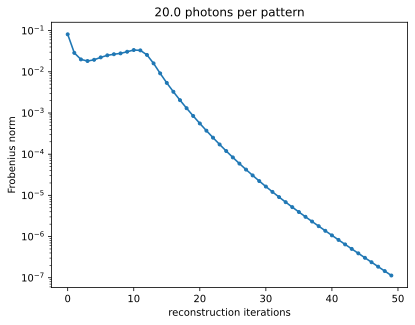

In [10]:
plt.plot(normList,'o-', linewidth=1.6, markersize=3)
plt.yscale('log')
plt.title("20.0 photons per pattern")
plt.xlabel("reconstruction iterations")
plt.ylabel("Frobenius norm")
plt.show()

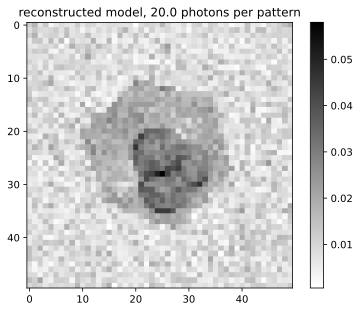

In [11]:
plt.imshow(dataRec, cmap="binary")
plt.title("reconstructed model, 20.0 photons per pattern")
plt.colorbar()
plt.show()

# Task_evil

### This task can be summarized in two steps:

- **Step1（Hit detection）：**  Find a threshold for the total photon count of a single image. The number of photon count <= threshold can be regarded as only contain blanks ($W_{b}$) ; The number of photon count > threshold can be regarded as contain hits and blanks($W_{b+s}$) . We rebuild our model with respect to the threshold
- **Step2（Model update）：** The EMC method was utilized for the reconstructed model, which contains a fixed-orientation background ($W_{b}$) and four orientational tomograms($W_{b+s}$).still run this step in a iterate process, when the difference reach the tolerence, get the real reconstructed model

**!!! Need to pay attention to normalization in the calculation process**

In [12]:
# show and get the evil dataset
emc_evil = emc(data_filename="data_evil.dat")
W_evil_ori=emc_evil.showAverageData()
# get the ground truth image
W_groundtruth=emc_evil.contrast

mean_total_photons: 50.000000


## Step 1

- K_set: contain all the pixel information on each image

### How to get the threshold, mathematics equation: 
$$Purity: P_{truehit}-P_{falsehit} = e^{-b}\sum_{k <= \mu}\frac{b^{k}}{k!}[1-e^{-b\Delta}(1+\Delta)^{k}]  $$
- b: average number of background photons per blank
- b(1+$\Delta$) : average number of background photons plus sample photons per hit

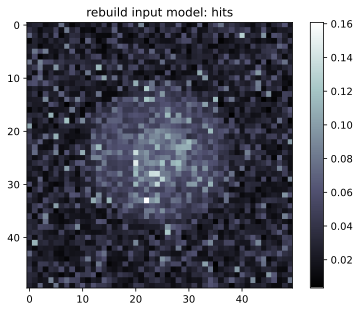

In [13]:
# sort all the k value
K_set=np.zeros((100000,2500))
for num_k in range(100000):
    K_set[num_k]=emc_evil.sparseToDense(num_k).flatten() #(2500)
    
#get the tot number of photon on each image and sort this dataset,record the sorted index to sort the K_set matrix
K_sorted_index = (np.sum(K_set,axis=1)).argsort()
photon_num = np.sort(np.sum(K_set,axis=1))
photon_uni = np.unique(photon_num)

# get the threshold of mu
hit_purity_all=[]
for mu in (photon_uni[:-1]):
    inter = np.argwhere(photon_num <= mu)[-1][0]+1
    b = np.mean(photon_num[:inter])# background photons
    b_plus = np.mean(photon_num[inter:]) # background photons plus sample photons
    k_mu = photon_num[:inter]
    # truehit-falsehit
    hit_purity = np.sum(np.exp(-b)* b**(k_mu)/factorial(k_mu)*[1-np.exp(-(b_plus-b))*(b_plus/b)**k_mu])
    hit_purity_all.append(hit_purity)
# threshold    
mu_max = photon_uni[np.argmax(hit_purity_all)]
# the location of the threshold
mu_max_loc = np.argwhere(photon_num == 67)[-1][0]+1

# rebuild the model based on threshold
#get the average background
K_sorted = K_set[K_sorted_index]
W_bg = (np.sum(K_sorted[:mu_max_loc],axis=0)/mu_max_loc).reshape(50,50)
W_bs = (np.sum(K_sorted[mu_max_loc:],axis=0)/(100000-mu_max_loc)).reshape(50,50)
W_input = np.array([W_bg,W_bs,np.rot90(W_bs),np.rot90(W_bs,k=2),np.rot90(W_bs,k=3)]) #5,50,50


# normalization parameter
fraction1 = mu_max_loc/100000
fraction2 = (100000-mu_max_loc)/100000


plt.imshow(W_bs, cmap='bone')
plt.title("rebuild input model: hits")
plt.colorbar()
plt.show()

## Step 2

In [14]:
# define the update function for evil dataset

def W_evil(W_j,data_name):
    '''
    Update input model
    ------------------------------
    Input: 
    W_j: input rebuilt model, contain contains a fixed-orientation background and four orientational tomograms
    data_name: just refer to the initial class name
    ------------------------------
    Return:
    W_j_set: updated model on the background and four orientational tomograms
    W_j_back: updated model on the background and four orientational tomograms which has been rotated back'''
    
    W_j_back=np.zeros((5,50,50))
    W_j_set=np.zeros((5,50,50))
    W_j=W_j.reshape(5,2500)
    
    # calculate all the likelihood
    prob_log = np.dot(np.log(W_j+np.finfo(float).eps),K_sorted.T)-np.sum(np.log(factorial(K_sorted)+np.finfo(float).eps),axis=1)[np.newaxis,:]-np.sum(W_j,axis=1)[:,np.newaxis]
    # prevent overflow        
    prob = np.exp(prob_log - np.max(prob_log))#(5,10000)
    # normalization
    prob_denominator = prob[0]*fraction1+ np.sum(prob[1:],axis=0)*fraction2
    prob[0] = prob[0]*fraction1/(prob_denominator)[np.newaxis,:]
    prob[1:] = prob[1:]*fraction2/ (prob_denominator)[np.newaxis,:]
    prob_nor = prob/np.sum(prob,axis=1)[:,np.newaxis]
    
    # update the pixel value using likelihood
    W_j_set=np.dot(prob_nor,K_sorted).reshape(5,50,50) #(4,2500),
    
    # rotate back
    W_j_back[0]= W_j_set[0]
    for j in range(1,5):
        W_j_back[j]= np.rot90(W_j_set[j],k=-(j-1))
    
    return W_j_set,W_j_back

In [15]:
# iteration process

delta=1
tol=1e-5
iter=0
delta_ele=[]
# initial input
pre_W= W_evil_ori

while delta > tol :
    iter+=1
    bs = np.mean(W_evil(W_input,emc_evil)[1][1:5],axis=0)
    bg = W_evil(W_input,emc_evil)[1][0]
    updated_W = bs * fraction2 + bg * fraction1
    delta=np.linalg.norm(updated_W- pre_W)
    pre_W = updated_W
    W_input = np.array([bg,bs,np.rot90(bs,k=1),np.rot90(bs,k=2),np.rot90(bs,k=3)])
    
    delta_ele.append(delta)

## Result


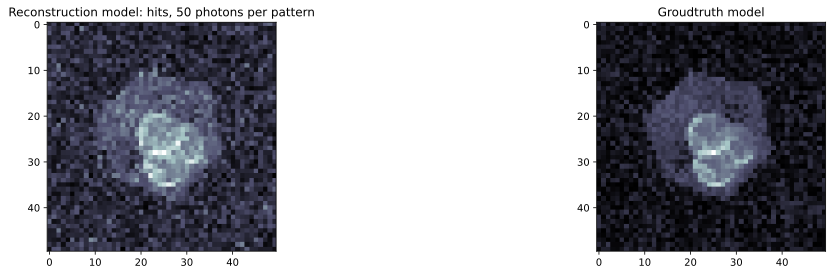

Pearsons correlation: 0.898 between ground truth model and the reconstructed model.

Pearsons correlation: 0.036 between ground truth model and the background noise.



In [16]:
combined_fig = plt.figure(figsize=(14, 7))

ax1 = combined_fig.add_subplot(131)
im1= ax1.imshow(bs,cmap ='bone')
ax1.set_title("Reconstruction model: hits, 50 photons per pattern")

ax2 = combined_fig.add_subplot(133)
im2 = ax2.imshow(W_groundtruth,cmap ='bone')
ax2.set_title("Groudtruth model")

plt.show()

corr1 = pearsonr(bs.flatten(),W_groundtruth.flatten())[0]
corr2 = pearsonr(bg.flatten(),W_groundtruth.flatten())[0]
print('Pearsons correlation: %.3f between ground truth model and the reconstructed model.\n' % corr1)
print('Pearsons correlation: %.3f between ground truth model and the background noise.\n' % corr2)

### Validation Part Using Pearson correlation coefficient
 ***The reason why do we use it is that the only relatve value among pixels in our reconstruction data matters.*** So we need the Pearson correlation coefficient to show us that reconstruction data indeed has the similar relationship among the pixels with the ground truth. So they will have the similar pattern.

The validation part tells us that our reconstruction data is good whose Pearson correlation coefficient is close to one, as constrast, the Pearson correlation coefficient of background noise is close to zero.

Text(0, 0.5, 'Frobenius norm')

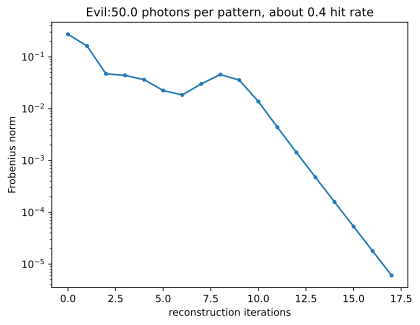

In [17]:
plt.plot(delta_ele,'o-', linewidth=1.6, markersize=3)
plt.yscale('log')
plt.title("Evil:50.0 photons per pattern, about 0.4 hit rate")
plt.xlabel("reconstruction iterations")
plt.ylabel("Frobenius norm")

# Compulsory discussion
Through the analysis of the model and training process, the following key insights were gained:
+ Refer to the probability like hit is correctly identified, the number of photons can serve as a threshold to effectively differentiate between hits and blanks.
+ Normalization plays a crucial role, particularly when the each image exhibits varying ratios with respect to the overall image.

We have to say that we learn a lot from 2D EMC. We practice the EM algorithm we learned from book which make us more familiar with how it work. And also we must say 2D EMC is a good idea, it can help to seperate different orientation pattern. And for background noise, we can also deal with it by just adding new dimension to our existing 4 dimensions and update. 

# Acknowledgement
Thanks for prof.Duane 's support and discussion.
### Source:
Loh, N. Duane. "A minimal view of single-particle imaging with X-ray lasers." Philosophical Transactions of the Royal Society B: Biological Sciences 369.1647 (2014): 20130328.